<a href="https://colab.research.google.com/github/aidaaminian/snn-self-driving/blob/main/bproj_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Install and Import

In [1]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
!unzip "/content/drive/MyDrive/bproj-dataset/traffic-sign-yolo.zip" -d "/content/home"

In [3]:
!pip install nengo
!pip install nengo-dl

In [4]:
%matplotlib inline
import nengo
import nengo_dl
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from urllib.request import urlretrieve

### Load Data

In [5]:
IMG_HEIGHT = 240
IMG_WIDTH = 240
minibatch_size = 32

In [6]:
dir_path = '/content/home/'

In [7]:
import cv2
import glob
image_list = []
for filename in glob.glob(dir_path + 'traffic-sign-yolo/*.jpg'):
    image = cv2.imread (filename)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    image = cv2.resize(image,(240,240))
    image_list.append (image)

### Data Preprocessing

In [8]:
np.array(image_list).shape

(741, 240, 240, 3)

In [9]:
image_list

[array([[[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [215, 218, 208],
         [215, 216, 203],
         [209, 220, 218]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [ 33,  35,  33],
         [ 57,  56,  46],
         [ 64,  92,  98]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [ 39,  48,  58],
         [ 35,  42,  48],
         [122, 131,  95]],
 
        ...,
 
        [[ 67,  70,  44],
         [ 71,  70,  75],
         [ 72,  71,  76],
         ...,
         [ 37,  37,  39],
         [ 35,  35,  38],
         [ 18,  32,  32]],
 
        [[ 62,  66,  41],
         [ 68,  69,  73],
         [ 73,  72,  76],
         ...,
         [ 38,  39,  40],
         [ 39,  39,  41],
         [ 22,  36,  37]],
 
        [[ 58,  62,  40],
         [ 68,  69,  73],
         [ 67,  67,  71],
         ...,
         [ 39,  40,  42],
  

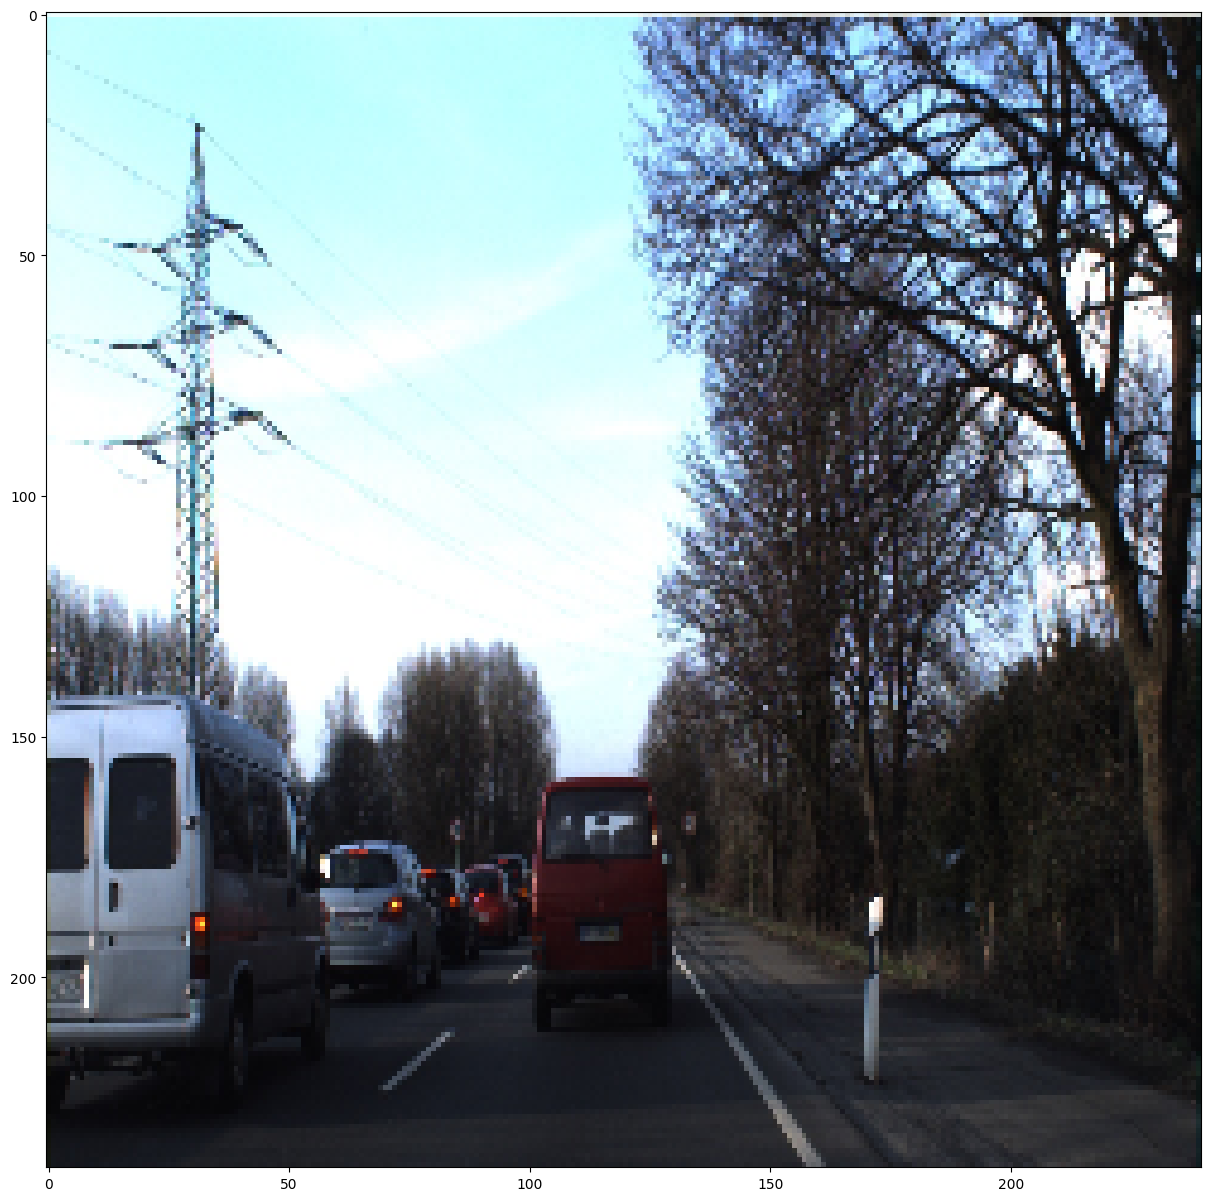

In [10]:
plt.figure(figsize=(15,15))
plt.imshow(image_list[8])
plt.show()

In [11]:
train_data = np.reshape(image_list, (len(image_list), -1))

In [12]:
train_data

array([[255, 255, 255, ...,  22,  36,  37],
       [246, 241, 237, ...,  34,  58,  62],
       [216, 214, 208, ...,  19,  33,  30],
       ...,
       [231, 241, 245, ...,  26,  50,  37],
       [232, 234, 222, ...,  10,  19,  16],
       [246, 241, 213, ...,  24,  40,  39]], dtype=uint8)

### Autoencoder Network

In [13]:
with nengo.Network(seed = 0) as auto_net:
    auto_net.config[nengo.Ensemble].max_rates = nengo.dists.Choice([200])
    auto_net.config[nengo.Ensemble].intercepts = nengo.dists.Choice([0])
    auto_net.config[nengo.Connection].synapse = None

    n_type = nengo.SpikingRectifiedLinear() 
    n_in = IMG_HEIGHT*IMG_WIDTH*3
    dim_hidden = 512

    input_node = nengo.Node(np.zeros(n_in))

    layer1 = nengo.Ensemble(dim_hidden, 1, neuron_type = n_type)
    nengo.Connection(input_node, layer1.neurons, transform=nengo_dl.dists.Glorot())

    layer2 = nengo.Ensemble(dim_hidden, 1, neuron_type = n_type)
    nengo.Connection(layer1.neurons, layer2.neurons, transform=nengo_dl.dists.Glorot())

    outp = nengo.Ensemble(n_in, 1, neuron_type=n_type)
    nengo.Connection(layer2.neurons, outp.neurons, transform=nengo_dl.dists.Glorot())

    p_c = nengo.Probe(outp.neurons)
    p_c_filt = nengo.Probe(outp.neurons, synapse=0.01, label="out_p_filt")